In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dog_epidemic.Utils as utils
from datetime import date
import numpy as np
import shapely
from shapely import Point
from shapely import Polygon
import random
import geopandas as gp
import geoplot as gpplt
import math
import numpy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

import jax
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS




/Users/emmagray/Library/Caches/pypoetry/virtualenvs/dog-epidemic-G0AQIdfE-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
all_dogs = gp.read_parquet('CurrentNYCDogs.parquet')

In [ ]:
all_dogs = all_dogs 
starting_zipcode = 11420
n_initially_infected = 5
n_generation_intervals = 30
distance = 0.03
buffer = 0.004
max_exposed_per_dog = 10
density_factor = 0.1

In [7]:
final_states, SEIR_Report, R_report = utils.run_simulation(
    all_dogs = all_dogs, 
    starting_zipcode = starting_zipcode, 
    n_initially_infected = n_initially_infected,
    n_generation_intervals = n_generation_intervals, 
    distance = distance, 
    buffer = buffer,
    max_exposed_per_dog = max_exposed_per_dog, 
    density_factor = density_factor)

Exposed dogs at generation 1 = 5
Exposed dogs at generation 2 = 5
Exposed dogs at generation 3 = 4
Exposed dogs at generation 4 = 2
Exposed dogs at generation 5 = 4
Exposed dogs at generation 6 = 5
Exposed dogs at generation 7 = 3
Exposed dogs at generation 8 = 4
Exposed dogs at generation 9 = 3
Exposed dogs at generation 10 = 8
Exposed dogs at generation 11 = 9
Exposed dogs at generation 12 = 14
Exposed dogs at generation 13 = 16
Exposed dogs at generation 14 = 16
Exposed dogs at generation 15 = 20
Exposed dogs at generation 16 = 23
Exposed dogs at generation 17 = 31
Exposed dogs at generation 18 = 37
Exposed dogs at generation 19 = 48
Exposed dogs at generation 20 = 55
Exposed dogs at generation 21 = 79
Exposed dogs at generation 22 = 86
Exposed dogs at generation 23 = 105
Exposed dogs at generation 24 = 125
Exposed dogs at generation 25 = 135
Exposed dogs at generation 26 = 148
Exposed dogs at generation 27 = 160
Exposed dogs at generation 28 = 197
Exposed dogs at generation 29 = 22

In [8]:

SEIR_Report.set_index('Step').to_csv('Reports/SEIR_report.csv')
R_report.set_index('Step').to_csv('Reports/R_report.csv')

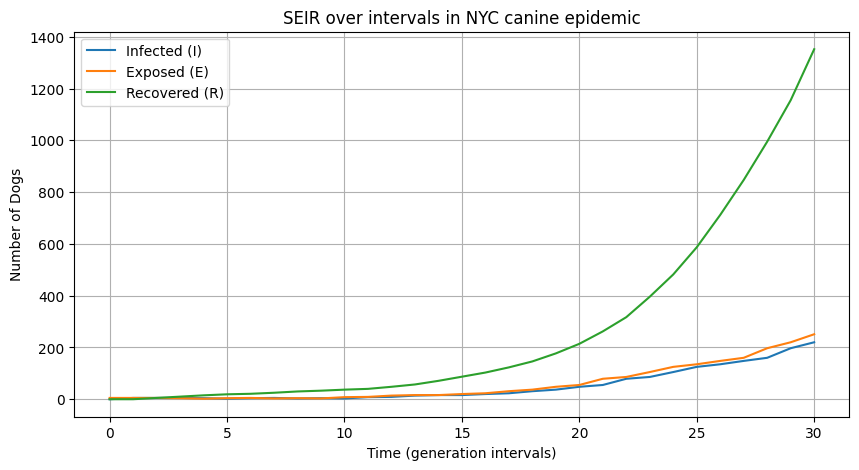

In [9]:

plt.subplots(figsize=(10, 5))
#plt.plot(range(n_generation_intervals + 1), SEIR_report['Susceptible'], label="Susceptible (S)")
plt.plot(range(SEIR_Report.shape[0]), SEIR_Report['Infected'], label="Infected (I)")
plt.plot(range(SEIR_Report.shape[0]), SEIR_Report['Exposed'], label="Exposed (E)")
plt.plot(range(SEIR_Report.shape[0]), SEIR_Report['Recovered'], label="Recovered (R)")
plt.xlabel("Time (generation intervals)")
plt.ylabel("Number of Dogs")
plt.title("SEIR over intervals in NYC canine epidemic")
plt.legend()
plt.grid(True)
plt.show()
plt.close()



In [10]:
counts_of_exposed = R_report.groupby(['Step', 'Exposed_ZipCode'], as_index=False)['Count'].sum()
counts_of_exposed = counts_of_exposed.rename(columns={"Exposed_ZipCode": "ZipCode"})
#counts_of_exposed['ZipCode'] = counts_of_exposed['Exposed_ZipCode']
all_dogs_count = all_dogs
all_dogs_count['Count'] = 1 
counts_all = all_dogs_count.groupby(['ZipCode', 'geometry'], as_index=False)['Count'].sum()


In [11]:
max_percent = 5
percent_exposed = pd.DataFrame()
percent_frame = 0

for step in range(counts_of_exposed['Step'].nunique()):
    counts_of_exposed_step = counts_of_exposed[counts_of_exposed['Step'] == step]
    counts_all['Step'] = step
    percent_exposed_step = pd.merge(counts_of_exposed_step.set_index('ZipCode'), 
                                counts_all.set_index('ZipCode'), 
                                on = ['ZipCode'], how = 'right',
                                suffixes = ('_exposed', '_all'),
                                indicator=True).drop(['_merge', 'Step_exposed'], axis = 1)
    percent_exposed_step['Count_exposed'] = percent_exposed_step['Count_exposed'].fillna(0)
    percent_exposed_step['percent_exposed'] = percent_exposed_step['Count_exposed']/percent_exposed_step['Count_all']*100
    percent_exposed = gp.GeoDataFrame(pd.concat([percent_exposed, percent_exposed_step], ignore_index=False))

    fig, ax = plt.subplots(1,1)
    plt.title("Percent of Dogs Exposed at Generation " + str(step))
    divider = make_axes_locatable(ax)
    ax.set_axis_off()
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    figname = 'Figures/' + 'percent_exposed' + str(percent_frame) + '.png'
    percent_exposed.plot(ax = ax, cax = cax, column = 'percent_exposed', cmap='RdPu', legend = True,
                         vmin = 0.0, vmax=max_percent, edgecolor = 'lightgray', linewidth = 0.25,
                         legend_kwds={"label": "Percent of Dogs Exposed", "orientation": "horizontal"},)
    fig.savefig(figname, format= 'png')
    plt.close(fig)
    percent_frame = percent_frame + 1


In [ ]:
import cv2
import os

image_folder = 'Figures'
video_name = 'video.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

SyntaxError: expected 'else' after 'if' expression (724044917.py, line 7)

In [18]:
from PIL import Image

In [21]:
images

['88.png',
 '77.png',
 '63.png',
 '62.png',
 '76.png',
 '89.png',
 '60.png',
 '74.png',
 '48.png',
 '49.png',
 '75.png',
 '61.png',
 '59.png',
 '65.png',
 '71.png',
 '70.png',
 '64.png',
 '58.png',
 '8.png',
 '72.png',
 '66.png',
 '67.png',
 '73.png',
 '9.png',
 '14.png',
 'percent_exposed16.png',
 '28.png',
 '29.png',
 '15.png',
 'percent_exposed17.png',
 'percent_exposed15.png',
 '17.png',
 'percent_exposed29.png',
 'percent_exposed28.png',
 'percent_exposed14.png',
 '16.png',
 '12.png',
 'percent_exposed10.png',
 '13.png',
 'percent_exposed11.png',
 '39.png',
 'percent_exposed13.png',
 '11.png',
 'percent_exposed8.png',
 'percent_exposed9.png',
 'percent_exposed12.png',
 '10.png',
 '38.png',
 '35.png',
 'percent_exposed23.png',
 '21.png',
 'percent_exposed4.png',
 'percent_exposed5.png',
 'percent_exposed22.png',
 '20.png',
 '34.png',
 '22.png',
 'percent_exposed20.png',
 '36.png',
 'percent_exposed7.png',
 'percent_exposed6.png',
 '37.png',
 '23.png',
 'percent_exposed21.png',
 'pe

In [32]:
images = [f'Figures/{i}.png' for i in range(n_generation_intervals * 3)]
images = [Image.open(image) for image in images]
gif_name = 'test.gif'
duration = 500 # duration per frame in milliseconds
images[0].save(gif_name, save_all=True, append_images=images[1:], duration=duration, loop=0)

In [34]:
images = [f'Figures/percent_exposed{i}.png' for i in range(n_generation_intervals)]
images = [Image.open(image) for image in images]
gif_name = 'test1.gif'
duration = 500 # duration per frame in milliseconds
images[0].save(gif_name, save_all=True, append_images=images[1:], duration=duration, loop=0)